# One Shot Learning with Siamese Networks

## Imports libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

## Helper functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class

In [4]:
class Config():
    training_dir = "/content/drive/MyDrive/VIP/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/training/"
    testing_dir = "/content/drive/MyDrive/VIP/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Data Visualization

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


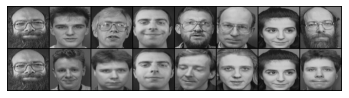

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8))

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
summary(SiameseNetwork().cuda(), [(1, 100, 100)]*2, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 102, 102]               0
            Conv2d-2          [-1, 4, 100, 100]              40
              ReLU-3          [-1, 4, 100, 100]               0
       BatchNorm2d-4          [-1, 4, 100, 100]               8
   ReflectionPad2d-5          [-1, 4, 102, 102]               0
            Conv2d-6          [-1, 8, 100, 100]             296
              ReLU-7          [-1, 8, 100, 100]               0
       BatchNorm2d-8          [-1, 8, 100, 100]              16
   ReflectionPad2d-9          [-1, 8, 102, 102]               0
           Conv2d-10          [-1, 8, 100, 100]             584
             ReLU-11          [-1, 8, 100, 100]               0
      BatchNorm2d-12          [-1, 8, 100, 100]              16
  ReflectionPad2d-13          [-1, 8, 102, 102]               0
           Conv2d-14          [-1, 8, 1

## Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001 )

In [19]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.5642471313476562

Epoch number 1
 Current loss 0.8149216175079346

Epoch number 2
 Current loss 1.1894104480743408

Epoch number 3
 Current loss 0.44904929399490356

Epoch number 4
 Current loss 0.41286516189575195

Epoch number 5
 Current loss 0.33120888471603394

Epoch number 6
 Current loss 0.27391624450683594

Epoch number 7
 Current loss 0.20734676718711853

Epoch number 8
 Current loss 0.12054356187582016

Epoch number 9
 Current loss 0.18380525708198547

Epoch number 10
 Current loss 0.11252210289239883

Epoch number 11
 Current loss 0.10920748114585876

Epoch number 12
 Current loss 0.1382695883512497

Epoch number 13
 Current loss 0.09253592789173126

Epoch number 14
 Current loss 0.06057043373584747

Epoch number 15
 Current loss 0.05275045335292816

Epoch number 16
 Current loss 0.040762759745121

Epoch number 17
 Current loss 0.03264841064810753

Epoch number 18
 Current loss 0.053260814398527145

Epoch number 19
 Current loss 0.05535686761140

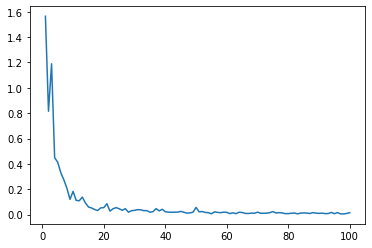

In [20]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=1
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Testing

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


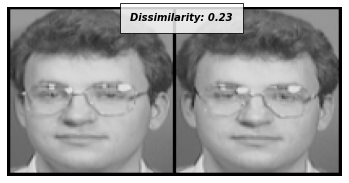

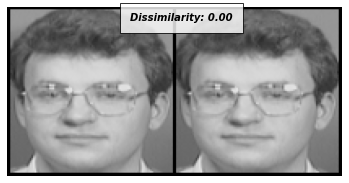

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


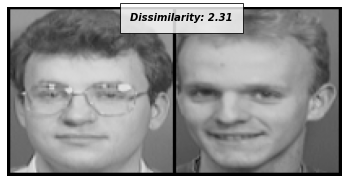

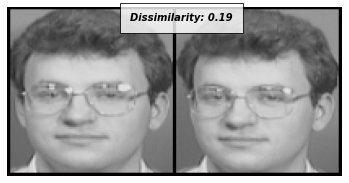

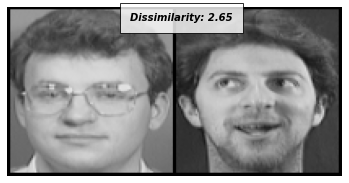

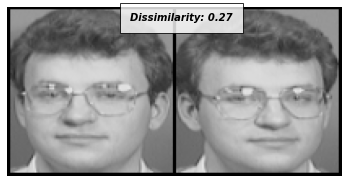

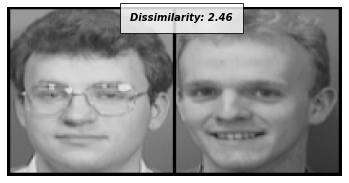

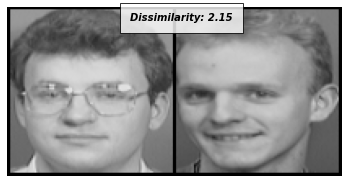

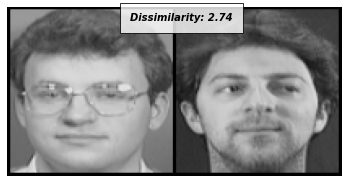

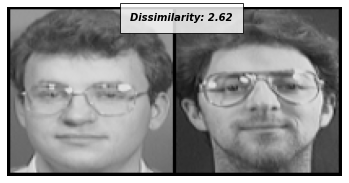

In [21]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Save and load model

In [22]:
torch.save(net.state_dict(), '/content/drive/MyDrive/VIP/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/model.pt')

In [23]:
net.load_state_dict(torch.load('/content/drive/MyDrive/VIP/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/model.pt'))

<All keys matched successfully>

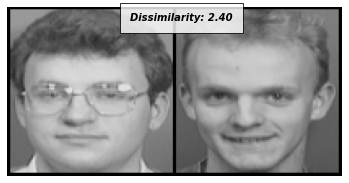

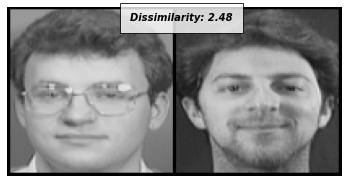

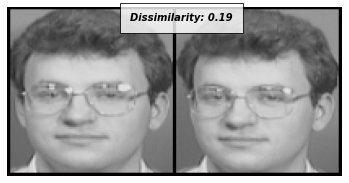

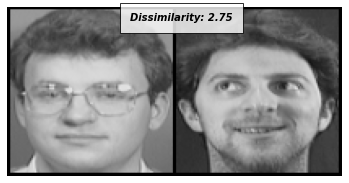

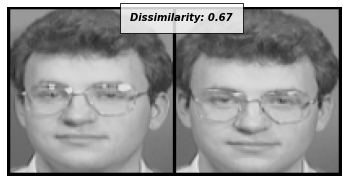

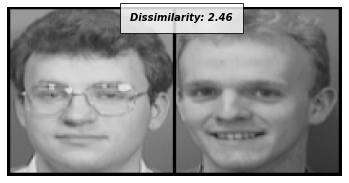

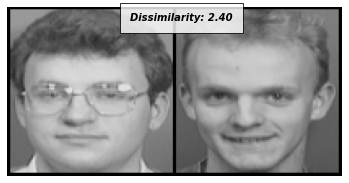

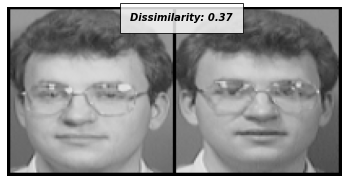

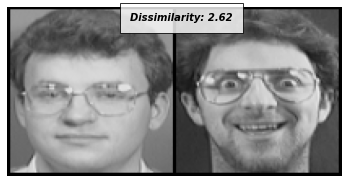

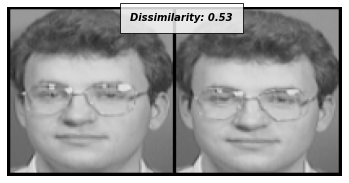

In [24]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

## Evaluation

In [25]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

In [26]:
def evaluation_metrics(model, data_loader, device="cuda"):
    model.eval()  # switch model to evaluation mode

    correct = 0
    total = 0

    true_positive = 0
    false_positive = 0
    false_negative = 0

    confusion_matrix = torch.zeros(2, 2, dtype=torch.int64)

    with torch.no_grad():  # no need to calculate gradients in evaluation mode
        for inputs1, inputs2, labels in data_loader:
            concatenated = torch.cat((inputs1,inputs2),0)
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            output1,output2 = model(Variable(inputs1),Variable(inputs2))
            euclidean_distance = F.pairwise_distance(output1, output2)

            predicted = (euclidean_distance.item() >= 1.0)  # make binary predictions based on a threshold of 1.0
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

            true_positive += ((predicted == 0) & (labels == 0)).sum().item() # 0 means no difference, 1 means different
            false_positive += ((predicted == 0) & (labels == 1)).sum().item()
            false_negative += ((predicted == 1) & (labels == 0)).sum().item()
            
            for i in range(labels.size(0)):
                confusion_matrix[int(labels[i].item()),int(predicted)] += 1

    accuracy = correct / total
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1_score))
    print("Confusion Matrix:")
    print(confusion_matrix.numpy())

    return accuracy, precision, recall, f1_score, confusion_matrix

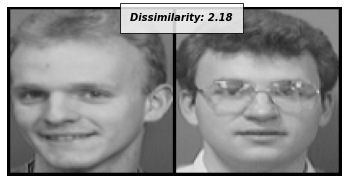

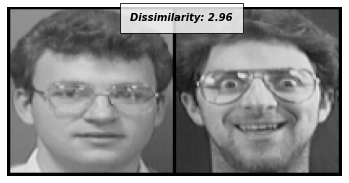

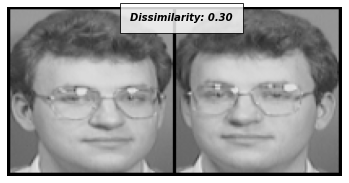

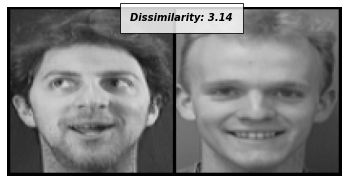

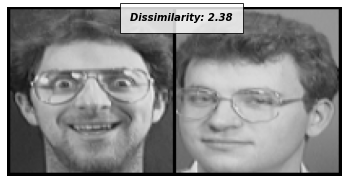

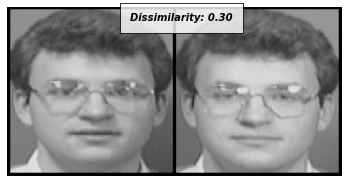

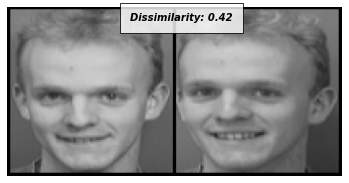

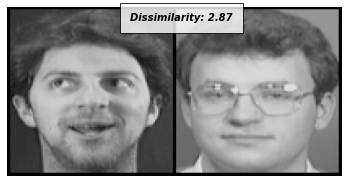

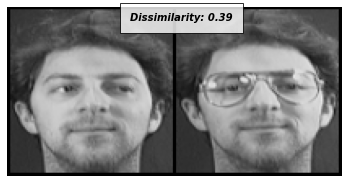

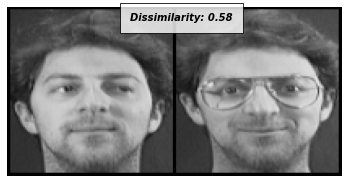

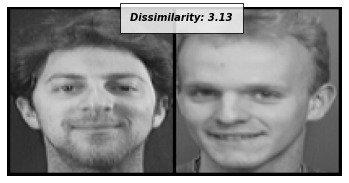

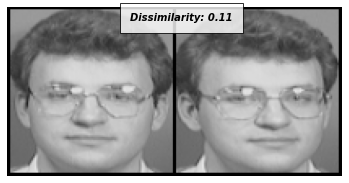

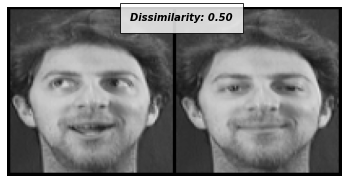

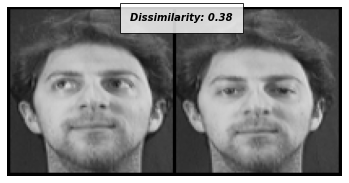

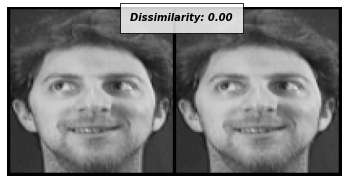

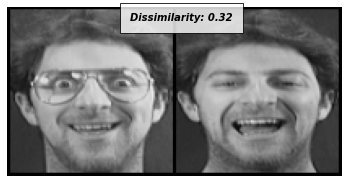

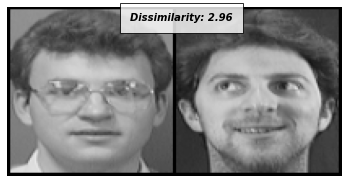

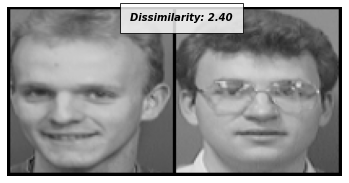

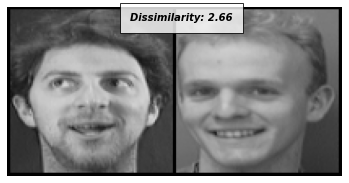

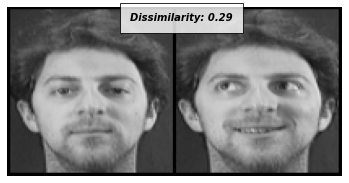

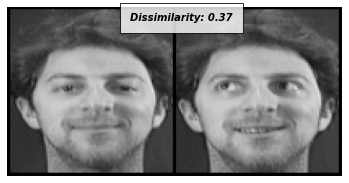

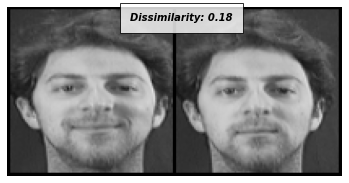

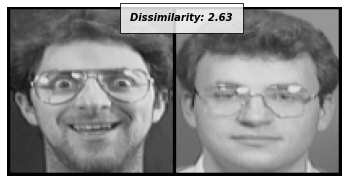

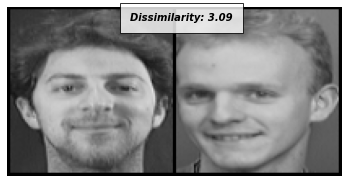

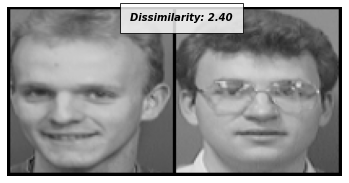

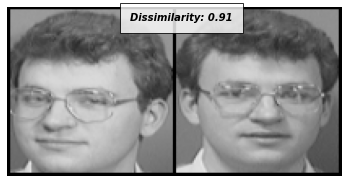

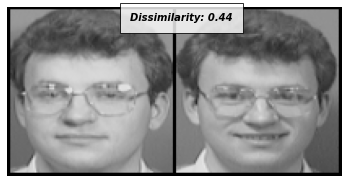

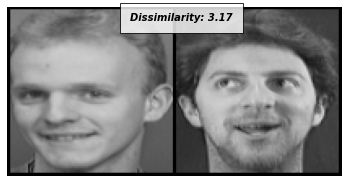

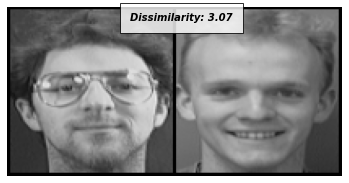

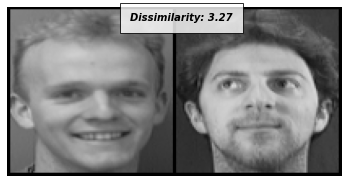

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00
Confusion Matrix:
[[15  0]
 [ 0 15]]


In [27]:
result = evaluation_metrics(net, test_dataloader)